In [2]:
%pip install git+https://github.com/forrestbao/pyeeg.git

  Cloning https://github.com/forrestbao/pyeeg.git to /tmp/pip-req-build-63_0afgf
  Running command git clone --filter=blob:none --quiet https://github.com/forrestbao/pyeeg.git /tmp/pip-req-build-63_0afgf
  Resolved https://github.com/forrestbao/pyeeg.git to commit a6c18bb093e4748f9d9c208535a6ae024a0802b8
  Preparing metadata (setup.py) ... done
  Created wheel for pyeeg: filename=pyeeg-0.4.4-py2.py3-none-any.whl size=28113 sha256=8f0c115f199ede1569a406d9934103fc76df1bc78621a04c662a811f4659cc39
  Stored in directory: /tmp/pip-ephem-wheel-cache-bozi56c3/wheels/b0/23/e4/703c908bda656959957029fa145879aa79307b2545a2ef0271
Successfully built pyeeg
  Attempting uninstall: pyeeg
    Found existing installation: pyeeg 0.0.2
    Uninstalling pyeeg-0.0.2:
      Successfully uninstalled pyeeg-0.0.2
Note: you may need to restart the kernel to use updated packages.


In [34]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import scipy.stats as stats 
import pyeeg 

from model.fgn import fractional_gaussian_covariance_series
from copulas.visualization import compare_3d

class FBm():

    def generate_gaussian_fBm(self, H1: float, H2: float, corr:float, size: int, drifts: list = [0.0, 0.0]) -> np.ndarray:

        means = np.zeros(2*size)     
        means[0:size] = means[0:size] + drifts[0]
        means[size:] = means[size:] + drifts[1]
                         
        result = np.random.multivariate_normal(means, 
                                               fractional_gaussian_covariance_series(size, H1, H2, corr))
        ts = np.ndarray((2, size))
        ts[0] = result[0:size]
        ts[1] = result[size:]

        return np.cumsum(np.insert(ts, 0, 0, axis=1), axis=1) 
    
    def hurst(self, X):
        return pyeeg.hurst(X) 

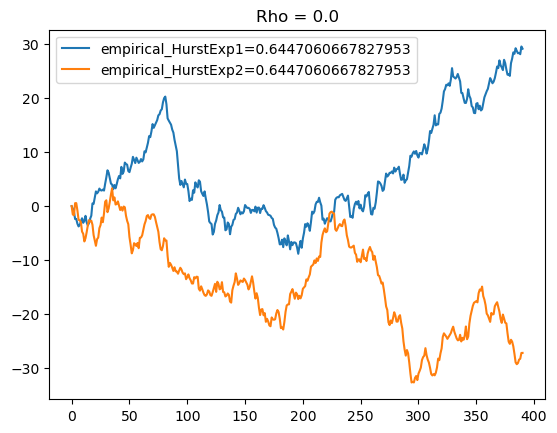

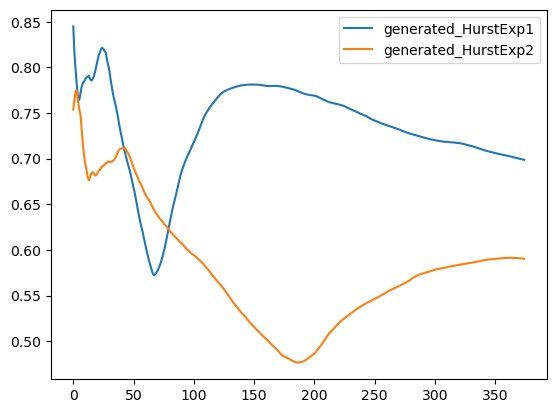

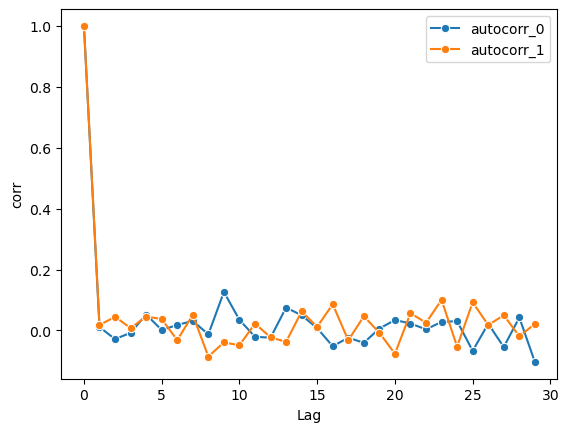

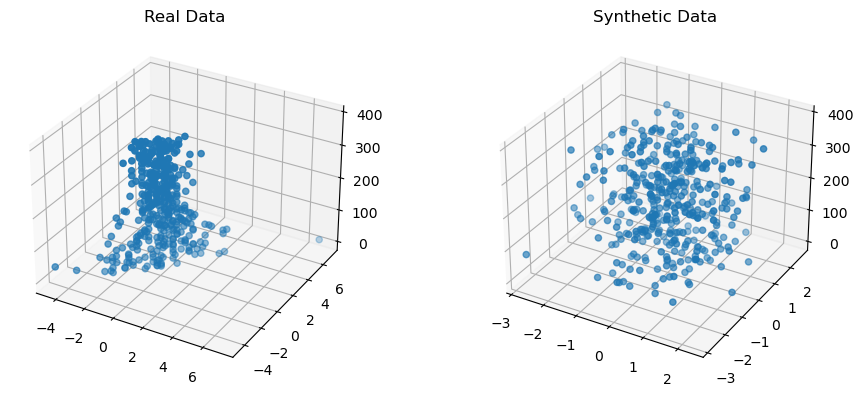

In [36]:
import pandas as pd 
tlt = pd.read_csv('./data/TLT_sample.csv')
tlt['marketClose'] = tlt['marketClose'].apply(np.log).diff().dropna()

mean0 = np.mean(tlt['marketClose']) 
mean1 = np.mean(tlt['marketClose'])
rho = 0.0

fbm = FBm()
H1 = fbm.hurst(tlt['marketClose'].dropna().values)
H2 = fbm.hurst(tlt['marketClose'].dropna().values)

size = len(tlt) - 1

ts = fbm.generate_gaussian_fBm(H1, H2, rho, size, [mean0, mean1]) 

diffed0=np.diff(ts[0])
diffed1=np.diff(ts[1])
plt.plot(ts[0], label=f"empirical_HurstExp1={H1}")
plt.plot(ts[1], label=f"empirical_HurstExp2={H2}")
plt.title(f"Rho = {rho}")
plt.legend()
plt.show()
plt.plot([ fbm.hurst(diffed0[:X]) for X in range(15, len(diffed0)) ], label=f"generated_HurstExp1")
plt.plot([ fbm.hurst(diffed1[:X]) for X in range(15, len(diffed1)) ], label=f"generated_HurstExp2")
plt.legend()
plt.show()

autocorr_df = pd.DataFrame()
autocorr_df['decay_0'] = np.diff(ts[0])
autocorr_df['decay_1'] = np.diff(ts[1])
decay_func = lambda S, _range: [S.apply(abs).autocorr(lag=Lag) for Lag in _range]

sns.lineplot(data=decay_func(autocorr_df['decay_0'], range(0, 30)), label='autocorr_0', marker='o')
sns.lineplot(data=decay_func(autocorr_df['decay_1'], range(0, 30)), label='autocorr_1', marker='o')
plt.xlabel('Lag')
plt.ylabel('corr')
plt.show()

three_df = pd.DataFrame() 
three_df['x'] = stats.zscore(np.diff(ts[0]))
three_df['y'] = stats.zscore(np.diff(ts[1]))
three_df['z'] = range(size)

orig_three_df = pd.DataFrame()
orig_three_df['x'] = stats.zscore(tlt['marketClose'].dropna().values)
orig_three_df['y'] = stats.zscore(tlt['marketClose'].dropna().values)
orig_three_df['z'] = range(len(tlt)-1)

compare_3d(orig_three_df, three_df)